# Exercise 11

## Muhammad Emzir

## Question 1

Consider the model
$$\begin{align}
x_{n+1} =& x_n + q_n,\\
y_n =& x_n + r_n,
\end{align}
$$
where $x_0,q_n,r_n \sim \mathcal{N}(0,1)$.

a. Simulate data from the model and implement a particle filter for the model. Compare its performance against Kalman filter.

b. As Kalman filter is exact for this model, particle filter should converge to it when the number of particles goes to infinity. Check numerically that the mean and variance sequences have that property.

Import some parts from previous exercises. You should know these already.

In [1]:
# %matplotlib widget
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg as sla
sns.set('talk')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from mpl_toolkits.mplot3d import Axes3D
fig_size = (8,8)
from typing import Callable

In [2]:
def propagate_linear_discrete_system_with_noise(F:np.ndarray,x_init:np.ndarray,v:np.ndarray):
    x = np.zeros((v.shape[0],x_init.shape[0]))
    x[0] = x_init
    for i in range(v.shape[0]-1):
        x[i+1] = F@x[i]+v[i]
    return x

In [3]:
def Kalman_filter(F,H,x_init,cov_init,Q_discrete,R_discrete,y):
    length = y.shape[0]
    x = np.zeros((length,x_init.shape[0]))
    P = np.zeros((length,x_init.shape[0],x_init.shape[0]))
    x[0] = x_init
    P[0] = cov_init
    for i in range(length-1):
        x_     = F@x[i]
        P_     = F@P[i]@F.T + Q_discrete
        S      = H@P_@H.T + R_discrete
        K_tran = sla.solve(S,H@P_)
        P[i+1] = P_ - K_tran.T@S@K_tran
        x[i+1] = x_ + K_tran.T@(y[i]-H@x_)
    return x, P

In [4]:
F = np.array([[1]])
H = np.array([[1]])
Q_discrete = np.array([[1]])
x_init = np.array([0.])
t_discrete = np.arange(1001)
R_discrete = np.eye(1)
q_discrete = np.random.multivariate_normal(np.zeros(1),Q_discrete,(t_discrete.shape[0]))
r_discrete = np.random.multivariate_normal(np.zeros(1),R_discrete,t_discrete.shape[0])

In [5]:
x = propagate_linear_discrete_system_with_noise(F,x_init,q_discrete)

In [6]:
y = x +r_discrete

In [7]:
x_kalman,cov_kalman = Kalman_filter(F,H,x_init,Q_discrete,Q_discrete,R_discrete,y)
stdev_kalman = np.sqrt(np.diagonal(cov_kalman,axis1=1,axis2=2))

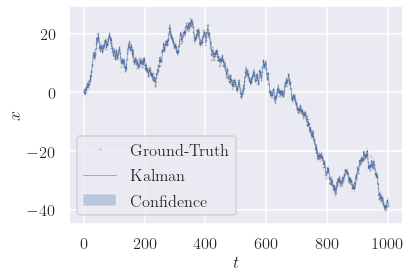

In [8]:
plt.plot(t_discrete, x, 'ok', markersize=1, label='Ground-Truth', alpha=0.2)
plt.plot(t_discrete,x_kalman, label='Kalman',linewidth=0.5)
plt.fill_between(t_discrete,x_kalman[:,0]-2*stdev_kalman[:,0],\
                 x_kalman[:,0]+2*stdev_kalman[:,0], label='Confidence',alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.legend()

Implementing the particle filter for a Gaussian case. We will use numpy vectorization here.

In [9]:
@partial(np.vectorize, signature='(n),(n,n)->()')
def gaussian_density(x:np.ndarray,cov:np.ndarray):
    return np.exp(-0.5*(x@cov@x))

@partial(np.vectorize, signature='(n),(n)->(n,n)')
def outer(x:np.ndarray,y:np.ndarray):
    return np.outer(x,y)

def particle_filter(f:Callable[[np.ndarray],np.ndarray],h:Callable[[np.ndarray],np.ndarray],
                            n_samples:int,x_init:np.ndarray,cov_init:np.ndarray,
                            Q_discrete:np.ndarray,R_discrete:np.ndarray,
                            y:np.ndarray,u=None):
    length = y.shape[0]
    n_state = x_init.shape[0]
    n_output = y.shape[1]
    x = np.zeros((length,n_state))
    P = np.zeros((length,n_state,n_state))
    x[0] = x_init
    P[0] = cov_init
    if u is None:
        u = np.zeros((length,1))
    
    x_particle = np.zeros((length,n_samples,n_state))
    q_particle = np.random.multivariate_normal(np.zeros(n_state),Q_discrete,(length,n_samples))
#     r_particle = np.random.multivariate_normal(np.zeros(n_output),R_discrete,(length,n_samples))
    w_particle = np.zeros((length,n_samples))
    w_particle[0] = np.ones(n_samples)/n_samples
    x_particle[0] = x[0]+q_particle[0]
    for i in range(length-1):
        x_particle[i+1] = f(x_particle[i],u[i])+q_particle[i]
        w_              = gaussian_density(y[i+1]-h(x_particle[i+1]),R_discrete)
        w_particle[i+1] = w_/np.sum(w_)
        
        x[i+1]          = w_particle[i+1]@x_particle[i+1]
        delta_          = x_particle[i+1]-x[i+1]
        P[i+1]          = np.tensordot(w_particle[i+1],outer(delta_,delta_),axes=([0],[0]))
    return x_particle,w_particle, x, P

In [10]:
@partial(np.vectorize, signature='(n),(m)->(n)')
def f_linear(x:np.ndarray,u:np.ndarray):
    return F@x

@partial(np.vectorize, signature='(n)->(n)')
def h_linear(x:np.ndarray):
    return H@x

In [16]:
x_particle, w_particle, x_pf, cov_pf = particle_filter(f_linear,h_linear,
                            n_samples=100,x_init=x_init,cov_init=Q_discrete,
                            Q_discrete=Q_discrete,R_discrete=R_discrete,
                            y=y)
stdev_pf = np.sqrt(np.diagonal(cov_pf,axis1=1,axis2=2))

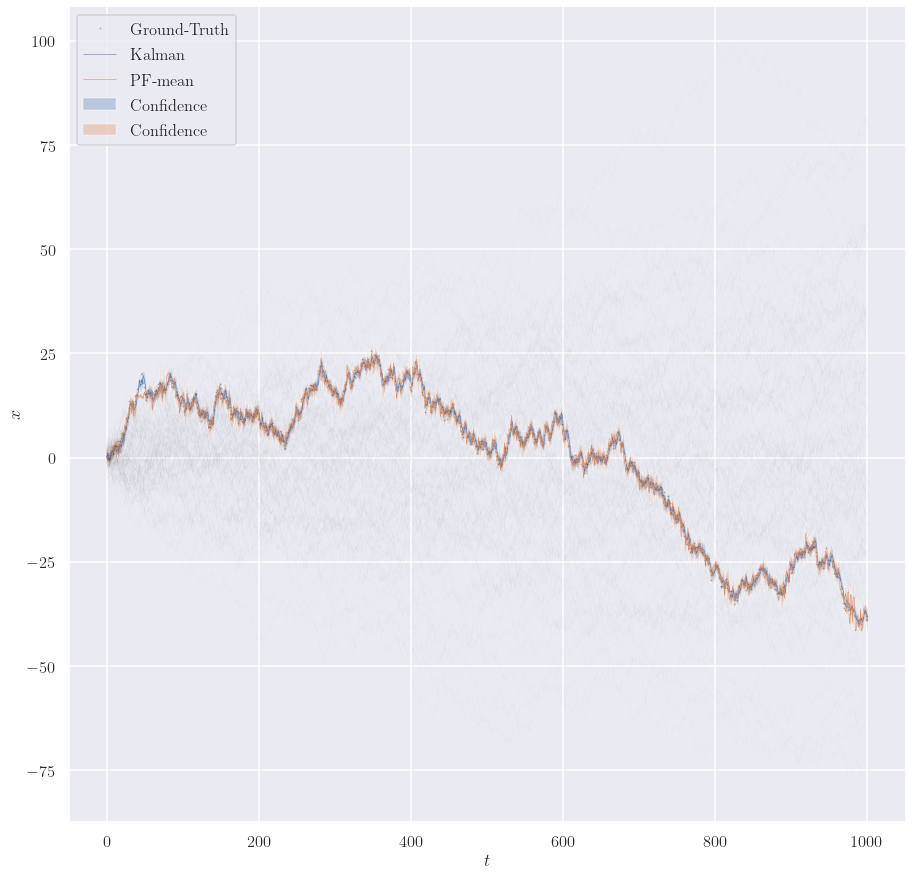

In [17]:
plt.figure(figsize=(15,15))
plt.plot(t_discrete, x, 'ok', markersize=1, label='Ground-Truth', alpha=0.2)
plt.plot(t_discrete,x_kalman, label='Kalman',linewidth=0.5)
plt.plot(t_discrete,x_pf, label='PF-mean',linewidth=0.5)
plt.fill_between(t_discrete,x_kalman[:,0]-2*stdev_kalman[:,0],\
                 x_kalman[:,0]+2*stdev_kalman[:,0], label='Confidence',alpha=0.3)
plt.plot(t_discrete,x_particle[:,:,0],'-k',linewidth=0.5,alpha=2/x_particle.shape[1])
plt.fill_between(t_discrete,x_pf[:,0]-2*stdev_pf[:,0],\
                 x_pf[:,0]+2*stdev_pf[:,0], label='Confidence',alpha=0.3)

plt.xlabel('$t$')
plt.ylabel('$x$')
plt.legend()

See the distribution of weight evolving with time

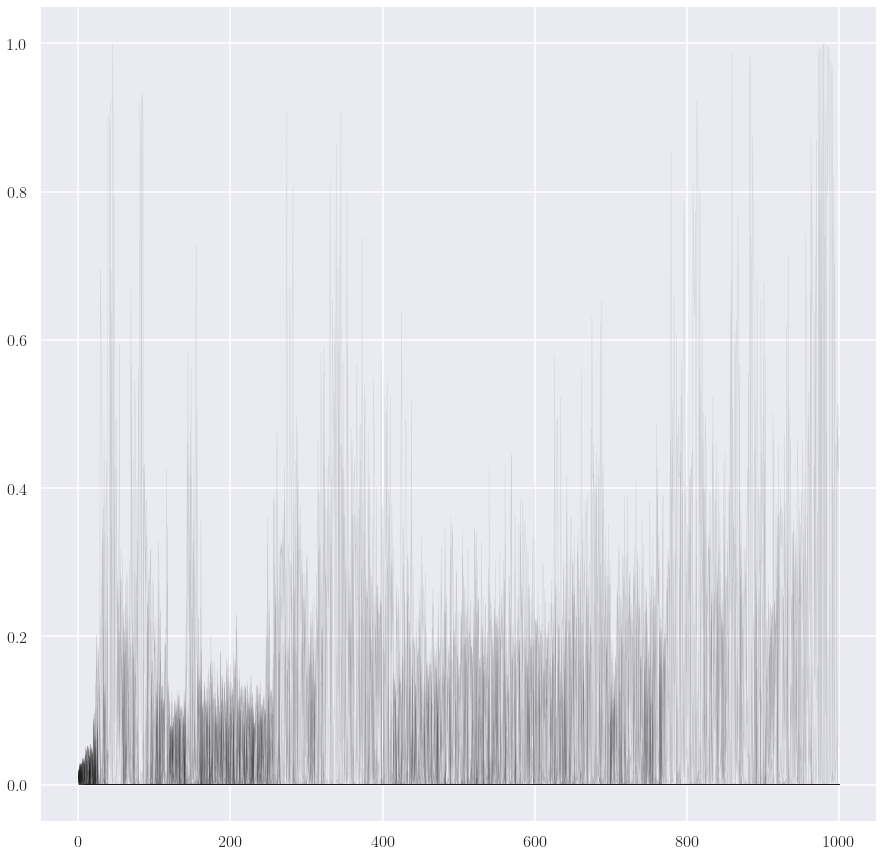

In [19]:
plt.figure(figsize=(15,15))
plt.plot(w_particle,'-k',linewidth=0.5,alpha=10/w_particle.shape[1])

## Sample impoverishment 

Sample impoverishment occurs when the region of state space in which the pdf $p(y_k|x_k)$ has singnificant values does not overlap with the pdf $p(x_k|y_{k-1})$. This means that if all of our apriori particles are distributed according to $p(x_k|y_{k-1})$, and then use the computed pdf $p(y_k|x_k)$ to resample the particles, only a few particles will be resampled to become a posteriori particles. This is because only a few of the apriori particles will be in a region of state-space where the computed pdf $p(y_k|x_k)$ has a significant value. This means that resampling proces will select only a few distinct apriori particles to become a posteriori particles. Eventually, all of the particles will collapse to the same value.

This problem will be exerbated if the measurements are not consistent with the process model (modelling errors).

Increasing the number of particle will help, but this is a dumb way. There are intelligent ways of dealing with this problem. One of them called Roughening. see Dan Simon, 15.3.1

## Question 2 (Particle filter for robot model)
Recall the robot tracking models from Exercises 10.2 and 10.3.

a. Implement a particle filter to the model with direct position measurements as in Exercise 10.2. Using the simulated data from 10.2, evaluate its performance against the EKF.

b. Modify the particle filter to work with distance and bearing measurements. Evaluate its performance against the EKF using the data from Exercise 10.3.

In [20]:
robot_init = np.array([0.5,0.5,np.pi/4])
# robot_init = np.array([0.,0.,0.])
t_robot = np.linspace(0.,5.,501)
dt_robot = t_robot[1]-t_robot[0]
u_robot = np.zeros((t_robot.shape[0],2))

for i in range(t_robot.shape[0]):
    if 0<= t_robot[i] < 1:
        u_robot[i,0] = t_robot[i]
    elif 1<= t_robot[i] < 4:
        u_robot[i,0] = 1
    else:
        u_robot[i,0] = 5-t_robot[i]
        
    if 0<= t_robot[i] < 2:
        u_robot[i,1] = 0
    elif 2<= t_robot[i] < 3:
        u_robot[i,1] = np.pi
    else:
        u_robot[i,1] = 0
        
def euler_maruyama_propagate(f:Callable[[np.ndarray,np.ndarray],np.ndarray], 
                              x_init:np.ndarray, w:np.ndarray, dt:float, u:np.ndarray=None):
    length = w.shape[0]
    if u is None:
        u = np.zeros((length,1))
    x_res = np.zeros((length,x_init.shape[0]))
    x_res[0] = x_init
    for i in range(x_res.shape[0]-1):
        x_res[i+1] = x_res[i] + f(x_res[i],u[i])*dt +  w[i]
    return x_res

In [21]:
Q_robot = np.diag([1e-2,1e-2,1e-2])
Q_robot_discrete = dt_robot*Q_robot
q_robot_discrete = np.random.multivariate_normal(np.zeros(3),Q_robot_discrete,(t_robot.shape[0]))
R_robot_discrete = 0.01*np.eye(2)
r_robot = np.random.multivariate_normal(np.zeros(2),R_robot_discrete,(t_robot.shape[0]))

In [22]:
@partial(np.vectorize, signature='(n),(m)->(n)')
def f_robot(x:np.ndarray,u:np.ndarray):
    return np.array([u[0]*np.cos(x[2]), u[0]*np.sin(x[2]), u[1]])

@partial(np.vectorize, signature='(n),(m)->(n)')
def f_robot_discrete(x:np.ndarray,u:np.ndarray):
    return x + f_robot(x,u)*dt_robot

@partial(np.vectorize, signature='(n)->(2)')
def h_robot(x:np.ndarray):
    return np.array([x[0],x[1]])

@partial(np.vectorize, signature='(n)->(2)')
def h_robot_2(x:np.ndarray):
    return np.array([np.sqrt(x[0]*x[0]+x[1]*x[1]),np.arctan2(-x[1],x[0])-x[2]])

In [23]:
x_robot = euler_maruyama_propagate(f_robot, robot_init, q_robot_discrete, dt_robot, u_robot)
y_robot = h_robot(x_robot)+r_robot
y_robot_2 = h_robot_2(x_robot)+r_robot

In [24]:
x_robot_particle, w_robot_particle, x_robot_pf, cov_robot_pf = particle_filter(f_robot_discrete,h_robot,
                            n_samples=50,x_init=robot_init,cov_init=Q_robot_discrete,
                            Q_discrete=Q_robot_discrete,R_discrete=R_robot_discrete,
                            y=y_robot,u=u_robot)
stdev_robot_pf = np.sqrt(np.diagonal(cov_robot_pf,axis1=1,axis2=2))

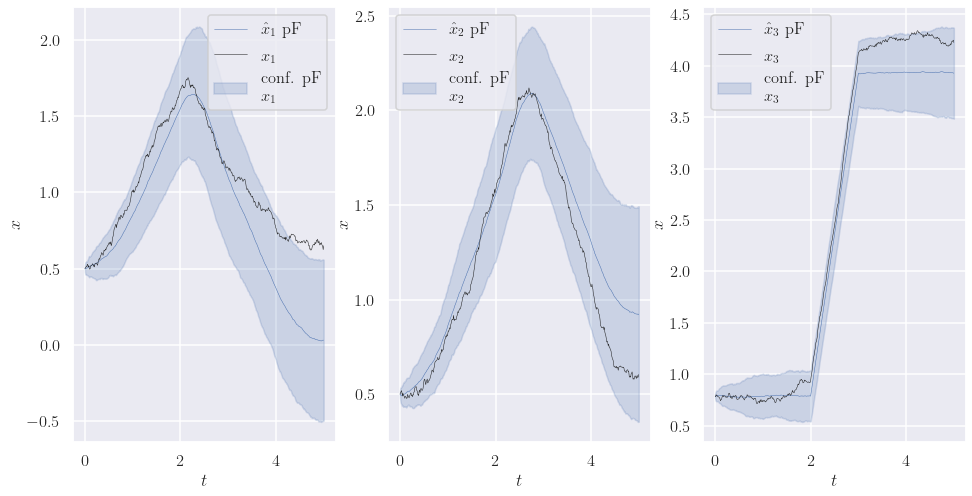

In [25]:
f, ax = plt.subplots(1,3,figsize=(2*fig_size[0],fig_size[1]))
for i in range(3):
    ax[i].plot(t_robot,x_robot_pf[:,i],linewidth=0.5, label='$\hat x_{}$ pF'.format(i+1))
    ax[i].fill_between(t_robot,x_robot_pf[:,i]-2*stdev_robot_pf[:,i],x_robot_pf[:,i]+2*stdev_robot_pf[:,i],label='conf. pF \n $x_{}$'.format(i+1),color='b',alpha=0.2)
    ax[i].plot(t_robot,x_robot[:,i],'-k',linewidth=0.5, label='$x_{}$'.format(i+1))
    ax[i].set_xlabel('$t$')
    ax[i].set_ylabel('$x$')
    ax[i].legend()

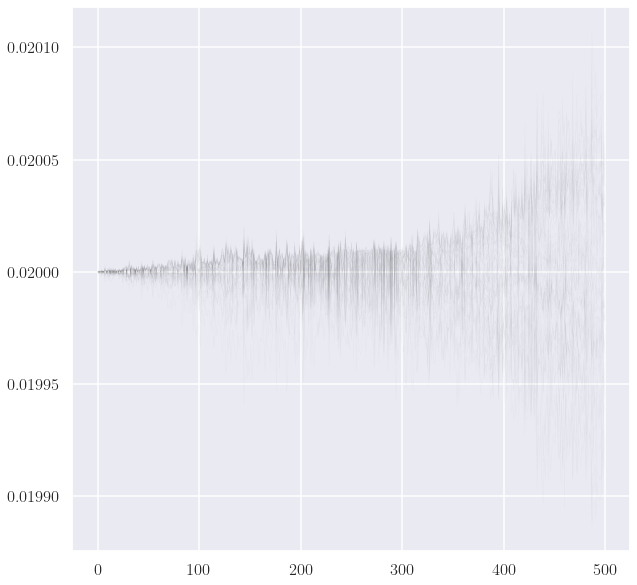

In [26]:
plt.figure(figsize=(10,10))
plt.plot(w_robot_particle,'-k',linewidth=0.5,alpha=1/w_robot_particle.shape[1])

In [27]:
x_robot_particle_2, w_robot_particle_2, x_robot_pf_2, cov_robot_pf_2 = particle_filter(f_robot_discrete,h_robot_2,
                            n_samples=50,x_init=robot_init,cov_init=Q_robot_discrete,
                            Q_discrete=Q_robot_discrete,R_discrete=R_robot_discrete,
                            y=y_robot_2,u=u_robot)
stdev_robot_pf_2 = np.sqrt(np.diagonal(cov_robot_pf_2,axis1=1,axis2=2))

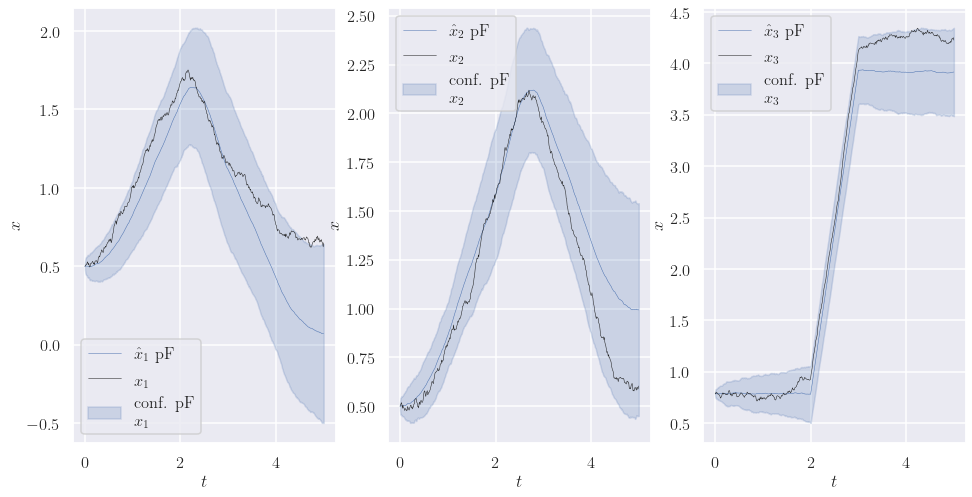

In [28]:
f, ax = plt.subplots(1,3,figsize=(2*fig_size[0],fig_size[1]))
for i in range(3):
    ax[i].plot(t_robot,x_robot_pf_2[:,i],linewidth=0.5, label='$\hat x_{}$ pF'.format(i+1))
    ax[i].fill_between(t_robot,x_robot_pf_2[:,i]-2*stdev_robot_pf_2[:,i],x_robot_pf_2[:,i]+2*stdev_robot_pf_2[:,i],label='conf. pF \n $x_{}$'.format(i+1),color='b',alpha=0.2)
    ax[i].plot(t_robot,x_robot[:,i],'-k',linewidth=0.5, label='$x_{}$'.format(i+1))
    ax[i].set_xlabel('$t$')
    ax[i].set_ylabel('$x$')
    ax[i].legend()

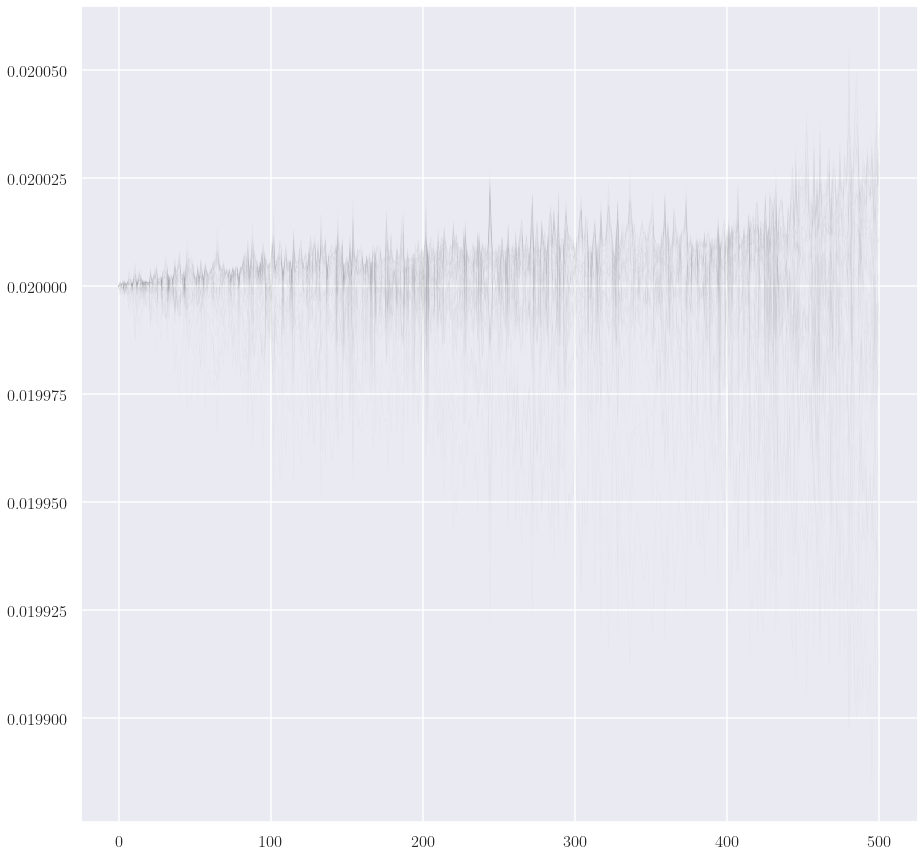

In [29]:
plt.figure(figsize=(15,15))
plt.plot(w_robot_particle_2,'-k',linewidth=0.5,alpha=1/w_robot_particle_2.shape[1])